<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Carry-out-operations-common-to-all-versions-of-data" data-toc-modified-id="Carry-out-operations-common-to-all-versions-of-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Carry out operations common to all versions of data</a></span></li><li><span><a href="#Preprocessing-and-predictive-modeling" data-toc-modified-id="Preprocessing-and-predictive-modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing and predictive modeling</a></span><ul class="toc-item"><li><span><a href="#Impact-of-not-dropping-endogenous-features,-etc." data-toc-modified-id="Impact-of-not-dropping-endogenous-features,-etc.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Impact of not dropping endogenous features, etc.</a></span></li></ul></li></ul></div>

This notebook tests how the data cleaning and feature engineering steps implemented in the previous notebook affect predictive accuracy.

To do this, I start by creating one large function that can carry out all those steps, but contains switches to allow us to only perform a subset of these transformations.

In [1]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

## Carry out operations common to all versions of data
Before actually defining this large function, we will perform a few essential steps we want to perform or all versions of the data. This will speed up our computations by avoiding unnecessary repetitions.`

After performing those steps comment all the data, we will save these partially cleaned data under a different name. For each version of the data we will create later, we can use this data frame is a starting point.

In [56]:
# Carry out operations common to all versions of data
# Get all the csv files in the data directory
files = glob.glob('data_raw/*.csv')

# Read those files into pandas
all_data_list = [pd.read_csv(file, header=1, low_memory=False) for file in files]

# Concatenate them into one DataFrame
all_data = pd.concat(all_data_list, ignore_index=True)
# Get rid of the individual DataFrames
del all_data_list 


# TEMPORARY:
# ---------
# Reduce number of observations next meet up computations
n_samples=100000
all_data = resample(all_data, replace=False, 
                    n_samples=n_samples, random_state=1)


# Create target variable
all_data['default'] = np.NaN
all_data.loc[all_data.loan_status.str.contains('Fully Paid', na=False), 'default'] = 0 
all_data.loc[(all_data.loan_status.str.contains('Charged Off', na=False)|
             (all_data.loan_status=='Default')), 'default'] = 1

# Set an impossible value to missing
all_data.loc[all_data.dti==-1, 'dti'] = np.nan

# Drop loans with indeterminate status
all_data = all_data.loc[all_data.default.notnull(),:]

# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns 
                           if all_data.loc[:,col] \
                                   .value_counts() \
                                   .shape[0] \
                                <= 1] 

# Delete those columns
all_data = all_data.drop(constant_or_missing + ['loan_status'], axis=1)

# Create hierarchical INDEX with date and ID,
# then save this version of the date as a basis for further transformations
all_data['issue_d'] = pd.to_datetime(all_data.loc[:,'issue_d'], format='%b-%Y')
all_data_partially_cleaned = all_data.set_index(['issue_d', 'id']).sort_index()


# Define endogenous and irrelevant columns, another columns to potentially drop
irrelevant = ['url', 'initial_list_status']
endogenous = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
              'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
              'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
              'debt_settlement_flag', 'last_fico_range_low', 'last_fico_range_high',
              'last_credit_pull_d']
lc = ['int_rate', 'grade', 'sub_grade']
other_to_drop = ['loan_amnt', 'funded_amnt_inv']


# Define function that creates different versions of data 
def make_data(df, v_to_drop=endogenous+lc+irrelevant+other_to_drop,
              drop_missing ='ideal', transform_time_since=True,
              transform_types=True, normalize_by_income=True,
              transform_skewed_v=True):
    """
    Creates different versions of data to compare performance of predictive
    models on data with different amount of cleaning, data engineering, etc.
    """
    
    # Start with the partially cleaned version of the data
    df = all_data_partially_cleaned
        
    # Drop ENDOGENOUS and IRRELEVANT variables
    # ------------------------------------------
    # Drop variables
    df = df.drop(v_to_drop, axis='columns')
    # Inform user about which variables were dropped
    print('\nEndogenous and irrelevant variables dropped: {}'
              .format(v_to_drop))

    
    ## MISSING VALUES
    # ---------------
    # Calculate the proportion of missing values for each variable
    missing = (df.isnull().sum()/df.shape[0]) \
                    .sort_values(ascending=False)
    variables_to_inspect = ['mths_since_last_record', 'mths_since_recent_bc_dlq',
                            'mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
                            'mths_since_last_delinq']
    # If specified, drop missing values as we found to be optimal in the data cleaning notebook 
    if drop_missing == 'ideal':
        variables_to_plot_1 = missing[missing>.75].index # Select columns
        # Create a list of variables to delete, and add all the plotted variables except the last two
        variables_to_drop = list(variables_to_plot_1[:-2])
        variables_to_plot_2 = missing[(missing <= .75) & (missing > .3)].index # Select columns   
        # Add variables to list of variables to delete
        variables_to_drop.extend([v for v in variables_to_plot_2 if v not in variables_to_inspect])
        variables_to_plot_3 = missing[(missing <= .3) & (missing > .005)].index # Select columns
        # Drop variables with too many missing values
        df = df.drop(variables_to_drop, axis='columns')
        # Inform user
        print('Dropping variables with missing values as determined to be optimal in '
              'the data cleaning notebook')
    
    # If the user-specified specified do not drop any variables, continue
    
    elif (drop_missing is None): 
        print('No variables were dropped due to missing values')
    
    # If specified, drop columns based on proportion of missing values
    else:
        # Get variables whose proportion of missing values exceeds threshold
        variables_to_drop = missing.loc[missing > drop_missing].index
        # Drop them
        df = df.drop(variables_to_drop, axis='columns')
        # Inform user about which variables were dropped
        print('Dropping variables with more than {}% missing values:\n{}' 
                .format(drop_missing * 100, variables_to_drop))


    # Transform "TIME-SINCE" variables
    # -------------------------------
    if transform_time_since: 
        # List to store transformed variables
        new_variables = []
        # Create a list with corresponding counts for each variables
        event_counts = ['pub_rec', None, None, None, 'delinq_2yrs']

        # Perform transformations
        for v, count in zip(variables_to_inspect, event_counts):
            # Get the variable and add 1
            v_transf = df.loc[:, v] + 1
            # Perform power transformation
            v_transf = v_transf ** -0.5
            # pdb.set_trace()
            # Set values to zero where event did not occur
            if count is not None: # If we have a count variable:
                # Get boolean mask where event did not occur
                zero_count = df.loc[:, count]==0
                # Set values to zero 
                v_transf.loc[zero_count] = 0
            else: # Where we don't h–ave event count, set all missings to zero
                v_transf = v_transf.fillna(0)

            # Store transformed variable
            new_variables.append(v_transf)

        # Concatenate transformd variables into data frame
        new_df = pd.concat(new_variables, axis='columns')
        ['inv_sqrt_1p_' + v for v in variables_to_inspect]
        # Add variable names
        new_df.columns = ['inv_sqrt_1p_' + v for v in variables_to_inspect]
        # Print proportion of non-missing observations
        # Add variables to our main data frame
        df = pd.concat([df, new_df], axis='columns')
        # Delete temporary data frame
        del new_df

        # Drop original variables
        df = df.drop(variables_to_inspect, axis='columns')
        
        # Inform user
        print('Transformed "time-since" variable')
        

    
    # Making sure variables are of the right TYPE
    # -------------------------------------------
    if transform_types:
        integers = [variable for variable in df.dtypes[df.dtypes==float].index
                        if df.loc[:, variable].apply(float.is_integer).all()]
        df[integers] = df.loc[:, integers].astype(int)

        # Convert objects to strings
        for variable in ['revol_util']:
            df[variable] = pd.to_numeric(df.loc[:, variable].str.replace('%', ''), errors='coerce')

        df['term_5y'] = np.nan
        df.loc[df.term.str.contains('60 months'), 'term_5y'] = 1
        df.loc[df.term.str.contains('36 months'), 'term_5y'] = 0


        df['earliest_cr_line'] = pd.to_datetime(df.loc[:, 'earliest_cr_line'], format='%b-%Y')

        # Create new variables  with time difference
        df['earliest_cr_line_days'] = \
            (df.reset_index(level='issue_d').issue_d.values
            - df.earliest_cr_line).dt.days

        # Mark original variables for deletion
        variables_to_drop_3 = 'earliest_cr_line'
        # Delete Variables
        df = df.drop(variables_to_drop_3, axis='columns')
        # Inform user
        print('Transformed types')
    

    # NORMALIZE monetary quantities BY INCOME
    # ---------------------------------------
    if normalize_by_income:
        df.assign(
            revol_bal_to_inc = 
                df.revol_bal / df.annual_inc,
            installment_to_inc = 
                (12*df.installment) / df.annual_inc,
            tot_coll_amt_to_inc = 
                df.tot_coll_amt / df.annual_inc,
            tot_cur_bal_to_inc = 
                df.tot_cur_bal / df.annual_inc,
            total_bal_ex_mort_to_inc = 
                df.total_bal_ex_mort / df.annual_inc)

        # Inform user
        print('Normalized monetary quantities by income')
        

    # If specified, transform SKEWED variables
    # ----------------------------------------

    if transform_skewed_v:
        # Inform the user
        print('Transformed overly-skewed variables')
        def mode_at_extremum(df):
            """
            Looks for variables where the mode occurs at the minimum or maximum.

            This is of interest because of censoring: Many variables have a natural
            minimum or maximum, e.g. 0 or 100%, respectively. 

            Parameters
            ----------
            df: pd.DataFrame
                Data frame whose variables to check .

            Returns
            -------
            tuple containing two lists
                First list contains names of variables whose mode occurs at the minimum.
                Second list contains names of variables whose mode occurs at the maximum.
            """

            # Get mode(s) for each variable in the data frame
            modes = df.mode()

            # Get minimum and maximum for each variable in the data frame
            minimum = pd.DataFrame(df.min())
            maximum = pd.DataFrame(df.max())

            # Loop over variables and save names of variables were mode occurs at an
            # extremum.
            mode_at_min = []  
            mode_at_max = []
            for variable in df:
                # Drop missing values from mode and try converting it to scalar
                try:
                    mode_ = np.asscalar(modes.loc[modes[variable].notnull(), variable])
                # If a variable contains multiple modes, we are not interested in it
                except ValueError:
                    pass

                else:
                    # Convert minimum and maximum to scalars
                    min_ = np.asscalar(minimum.loc[variable])
                    max_ = np.asscalar(maximum.loc[variable])

                    # Test whether minimum or maximum occurs at the mode
                    if (mode_ == min_):
                        mode_at_min.append(variable)
                    elif (mode_ == max_):
                        mode_at_max.append(variable)

            return(mode_at_min, mode_at_max)

        numerics = all_data.select_dtypes(include=[np.number]).columns.tolist()
        mode_at_min, mode_at_max = mode_at_extremum(all_data.loc[:, numerics])

        

        def find_mixtures(df, variables, n_unique_threshold=10,
                          proportion_threshold=0.01, ratio_threshold=5, 
                          verbose=False):
            """
            Identify variables for which we should include a dummy for overly frequent unique values.

            For each variable in a DataFrame, identify unique values that occur so often that
            this variable is best modeled as being generated by a mixture process. I 
            operationalize such a value as occurring at least 10 times as often as would be 
            expected if all unique values occurred with the same frequency. For example, if
            the variable has 15 unique values, 

            A mixture process looks as follows:
            First, a Bernoulli variable determines if the variable takes on a particular discrete 
            value. This may be repeated for other particular discrete values.  If this is not 
            the case, the value is drawn from a different process such as a normal or poisson
            distribution. 

            Parameters
            ----------
            df: pd.DataFrame
                Data frame containing the variables to analyze.
            variables: list
                Variables, located in df, which to check. Usually these will be variables that
                have their mode at their minimum or maximum (e.g., the output from
                mode_at_extremum() ).
            n_unique_threshold: int
                The minimum number of unique values of variable must have in order to be 
                considered.
            proportion_threshold: numeric, optional
                The minimum proportion of observations in the samples that must have the most
                frequent value in order for the variable to be considered. This can be used to
                filter out variables where no value occurs frequently. Default: 1%.
            ratio_threshold: numeric, optional
                Threshold to use for the ratio of the most frequent to the second-most frequent 
                count. If it is exceeded, the variable will be treated as a deriving from a 
                mixture distribution. Default: 5
            verbose: bool
                If true, print out the ratio of the most frequent to the second-most frequent
                count for each variable. Default: False

            Returns
            -------
            list
                Names of variables that seem to derive from a mixture distribution.
            """

            mixtures = []
            # Go through all variables and look for mixtures
            for variable in variables:
                # Count unique values
                valuecounts = df.loc[:, variable].value_counts()

                # Skip variables whose number of unique values does not exceed the
                # supplied threshold
                if len(valuecounts) < n_unique_threshold:
                    continue

                # Skip variables where no single value occurs frequently 
                if valuecounts.iloc[0] < proportion_threshold * len(df):
                    continue

                # Compute ratio of occurrence of most-frequent to second-most frequent value
                ratio = valuecounts.iloc[0] / valuecounts.iloc[1]

                # If ratio is greater than the threshold, save variable name
                if ratio > ratio_threshold:
                    mixtures.append(variable)

            return(mixtures)

        def add_mixture_dummies(df, mixture_min, mixture_max):
            # Initialize dictionary to store dummy variables
            mixture_dummies = {}
            # Create dummies for variables with mode at maximum
            for variable in mixture_max:
                dummy_name = 'max_' + variable
                mixture_dummies[dummy_name] = df.loc[:, variable] == \
                                              df.loc[:, variable].max()

            # Create dummies for variables with mode at minimum
            for variable in mixture_min:
                dummy_name = 'min_' + variable
                mixture_dummies[dummy_name] = df.loc[:, variable] == \
                                              df.loc[:, variable].min()

            # Create data frame with all dummies
            mixture_dummies = pd.DataFrame(mixture_dummies)
            # pdb.set_trace ()
            # Add dummies to original data
            df = pd.concat([df, mixture_dummies], axis='columns')

            return(df)

        def find_mixtures_add_dummies(df, dry_run=True, **kwargs):
            """
            Identify variables for which we should include a dummy for overly frequent 
            unique values. Print variable names or go ahead and add dummies.

            Identify numeric variables where we should add a dummy variable for the mode to
            model the extreme skewness that results from mixture processes such as
            zero-inflation. 

            For each numeric variable in a DataFrame, identify unique values that are 
            located at the minimum or maximum, and that occur so often that this variable is
            best modeled as being generated by a mixture process. The decision rule is
            based on the ratio of the most frequent count to the second-most frequent
            count. By default, this threshold is set to 5.

            The subset of mixture processes we are interested in here look as follows:
            First, a raw from a Bernoulli distribution decides if the variable takes on
            a particular discrete value (often 0 for counts or 100% for proportions). 
            If this is not the case, the variable's value is drawn from a different
            distribution such as a normal or poisson distribution. For simplicity, 
            this subtype of mixture process will simply be referred to as a mixture 
            process, since there is no more exact term.

            Parameters
            ----------
            df: pd.DataFrame
                Data frame to inspect and modify.
            dry_run: bool, optional
                Whether to simply print for which variables would be added, or whether
                to actually add those dummies to the input data frame. Default: only
                print variable names.
            **kwargs
                Additional arguments to change the defaults of find_mixture():
                n_unique_threshold, ratio_threshold, proportion_threshold, verbose.
            """

            # Consider only variables that are numeric
            numerics = df.select_dtypes(include=[np.number]).columns.tolist()

            # First find variables where mode occurs at minimum or maximum
            mode_at_min, mode_at_max = \
                mode_at_extremum(df.loc[:, numerics])

            # Find which of those variables have an inflated number of 
            # minimum or maximum values
            mixtures_at_min = find_mixtures(df, mode_at_min, **kwargs)
            mixtures_at_max = find_mixtures(df, mode_at_max, **kwargs)

            # If specified, add dummies to original data and also return the
            # names of variables for which a dummy was added
            if dry_run != True: 
                return(add_mixture_dummies(df, mixtures_at_min, mixtures_at_max),
                       mixtures_at_min, mixtures_at_max)


        # Print names of variables for which dummies will be added
        find_mixtures_add_dummies(df, proportion_threshold=0.001) 

        # Add dummies and save lists of variables for which we created dummies
        df, min_dummies, max_dummies = find_mixtures_add_dummies(df, dry_run=False, proportion_threshold=0.001)
        df.columns

        def skewness(data, ignore_min=[], ignore_max=[], 
                     verbose=True, n_threshold=5):
            """
            Returns the skewness of each variable in a Series or DataFrame.

            Skewness is operationalized as follows: 
            log((Upper Quartile - Median)/(Median - Lower Quartile)
            If the median falls on the same value as either the upper or lower quartile, the 
            resulting zero is replaced by a very small number in order to avoid taking the 
            log of zero or dividing by zero, respectively. If all three quartiles fall on 
            the same value, no skewness score is produced because our measure is not
            appropriate for such extremely skewed cases. 

            Parameters
            ----------
            data : Series or DataFrame
                Variable to transform.
            n_threshold : int
                Minimum number of unique values to compute skewness
            verbose : bool
                Whether to inform users for which variables the minimum or maximum was 
                discarded, and for which variables the skewness score is likely unreliable
                due to a low number of unique values.  This should only be turned off if
                those problematic variables have been removed beforehand. Default: True

            Returns
            -------


            If input is of type pd.Series:
                float
                    skewness
            """

            # Make a copy of the input data to operate on
            x = copy.copy(data)

            # Compute number of unique values for each variable
            if verbose == True:
                n_unique = x.nunique()

            # Start by trying to treat the input as a SERIES:
            try:
                # First check whether we need to remove the mode. If so, set to missing
                if x.name in ignore_min:
                    x.loc[x==x.min()] = np.nan
                elif x.name in ignore_max:
                    x.loc[x==x.max()] = np.nan

                # Compute quartiles 
                quartiles = x.quantile(q=[.25, .5, .75])          
                upper_width = quartiles[.75] - quartiles[.5]
                lower_width = quartiles[.5] - quartiles[.25]

                # If the three quartiles do NOT fall on the same value, calculate skewness
                if (upper_width != 0) or (lower_width != 0):
                    # If only the lower and middle quartile fall onto the same value, set 
                    # their difference to a very small number to avoid introducing missing 
                    # values due to division by zero.
                    if lower_width == 0:
                        lower_width = .000001
                        # Do the same for the difference between upper quartile and median, 
                        # since a zero here would prevent us from taking the log later.
                    elif upper_width == 0:
                        upper_width = .000001
                    else: # Is there a better way of putting this?
                        pass

                    # Calculate skewness score
                    skewness = np.log(upper_width / lower_width)
                    # If skewness cannot be computed (for reasons other than all three 
                    # variables falling onto the same value, which is addressed below),
                    # a variable. 
                    if not np.isnan(skewness):
                        v_problem = [] # Make it a list for consistency with DataFrames
                    else:
                        v_problem = [x.name]  

                # If all three quartiles fall onto the same value, set skewness to missing
                else:
                    skewness = np.nan        
                    v_problem = []


            # If treating the input data as Series doesn't work, treat it as DATAFRAME
            except AttributeError:   # Because DataFrame doesn't have name attribute
                # Remove min or max from variables where we included a dummy for it
                for variable in x:
                    if variable in ignore_min:
                        x.loc[x[variable] == x[variable].min(), variable] = np.nan
                    elif variable in ignore_max:
                        x.loc[x[variable] == x[variable].max(), variable] = np.nan


                # The following code applies to both SERIES and DATAFRAMEs again:
                # Compute quartiles and distance between them
                quartiles = x.quantile(q=[.25, .5, .75])          
                upper_width = quartiles.apply(lambda col: col[.75] - col[.5])
                lower_width = quartiles.apply(lambda col: col[.5] - col[.25])

                # Flag location of variables where all three quartiles fall onto the same value, 
                # so that we can set skewness to missing later (because our measure cannot 
                # deal with such extreme cases.
                extreme_skew = (upper_width == 0) & (lower_width ==0)    
                v_no_skewness = x.columns[extreme_skew].tolist()

                # If the difference between lower quartile and median is zero, set it to a very small
                # number to avoid introducing missing values due to division by zero.
                lower_width[lower_width == 0] = .000001
                # Do the same for the difference between upper quartile and median, since a zero
                # here would prevent us from taking the log later
                upper_width[upper_width == 0] = .000001

                # Calculate skewness score
                skewness = np.log(upper_width / lower_width)

                # Identify any missing values for skewness (Note that this is BEFORE
                # we manually added missing values for variables where all three quartiles 
                # fall onto the same value)
                if np.isnan(skewness).any():
                    v_problem = skewness[skewness.isnull()].index.tolist()

                else:
                    v_problem = []  

                # Set skewness for variables where all three quartiles fall onto 
                # the same values to missing
                skewness.loc[extreme_skew] = np.nan

            return(skewness, v_problem)

        def log_or_log1p(s):
            """ Returns the log of all strictly positive variables and the log(1+x) 
            of all non-negative variables. Ignores variables with any negative value. 

            Args: s, pd.Series

            """

            # Raise error for log(0) rather than producing NaNs
            with np.errstate(all='raise'):
                # Try taking log
                try:
                    # Exclude missing values manually
                    log = np.log(s[s.notnull()])
                    log.name = 'log_' + s.name

                    return(log)

                except FloatingPointError:
                    pass  # To avoid nesting

                # If this fails, try taking log(1+x)
                try:
                    log1p = np.log1p(s[s.notnull()]) 
                    log1p.name = 'log1p_' + s.name
                    return(log1p)        

                # If this still doesn't work, the variable contains 
                # negative values, so return None.
                except FloatingPointError:
                    return(None)

                
        def transform_skewness(df, min_dummies, max_dummies,
                               n_threshold_ignore=3, n_threshold_warn=10, 
                               take_log=[], ignore=[], dry_run=True):
            """Applies log-transformation to each variable in a DataFrame where it 
            reduces skewness.

            Only numeric variables with at least 10 unique values are considered (since

            Parameters
            ----------
            df : pd.DataFrame
                Data to diagnose or transform
            min_dummies : list
                Variables for which all minimum values should be ignored when
                computing skewness.
            max_dummies : list
                Variables for which all maximum values should be ignored when
                computing skewness.
            n_threshold_ignore : int
                Specifies the minimum number of unique values a variable must 
                exceed in order to be considered.
            n_threshold_warn : int
                Specifies the minimum number of unique values a variable must
                exceed so that the user is not warned to examine it manually.
            take_log : list, optional
                Variables for which you take the log without examining them first.
                This is particularly useful after already having performed a 
                manual diagnosis during the dry-run. Default: Empty list.
            ignore : list, optional
                Variables to ignore. Default: Empty list.
            dry_run : boolean
                If False, performs the transformations.  If True, prints which
                transformations would be performed, along with some additional 
                information. Default: False.

            Returns
            -------
            If dry_run == False:
                df_new : pd.DataFrame
                    Transformed data
                df_deleted_v: pd.DataFrame
                    Deleted (untransformed) variables

            If dry_run == True:
                None

            """

            # Make sure arguments are of the right type
            if not isinstance(take_log, list):
                raise TypeError('take_log must be of type list.')
            if not isinstance(ignore, list):
                raise TypeError('ignore must be of type list.')

            ## Select only relevant variables
            # Get names of all the numeric features
            v_numeric_all = df.select_dtypes(include=[np.number]).columns.tolist()
            # Disregard variables that user-specified to ignore
            v_numeric = [v for v in v_numeric_all if v not in ignore]
            # Count the number of unique values for each numeric variable
            n_unique = df.loc[:, v_numeric].nunique()
            # Ignore variables with very low counts (and save their names)
            v_very_low_count = n_unique.loc[n_unique <= n_threshold_ignore]

            # Make a list of transform  candidates that excludes variables that are
            # not numeric or have very low counts of unique values
            transform_candidates = [v for v in v_numeric if v not in v_very_low_count]

            # Save variables with moderately low number of unique values, so that
            # we can suggest to examine them manually
            v_low_count = n_unique.loc[(n_unique <= n_threshold_warn) & 
                                       (n_unique > n_threshold_ignore)]


            ##  Try log transformation
            # Calculate skewness before transformation (if we added a dummy for
            # min or max, ignore those values and calculate skew for other values only)
            skew_level, v_problem_level = skewness(df.loc[:, transform_candidates], 
                                                  ignore_min=min_dummies, 
                                                  ignore_max=max_dummies,
                                                  n_threshold=n_threshold_ignore,
                                                  verbose=False)

            # Create list to store transformed variables if they are less skewed
            v_to_transform = []
            # Create a list of the variables to delete because they were transformed
            v_to_delete = []
            # Create list to store variables where transformation failed due to 
            # negative values
            v_negative = []
            # Create list to store variables where transformation failed for 
            # other reasons
            v_trans_failed = []
            # Create a list to store variables where user-specified to take the log
            # either way but it was not possible.
            v_take_log_problem = []
            # Create a list to store variables where a problem occurred computing the
            # skewness (other than the three quartiles falling onto the same value)
            v_problem_log = []
            # Create lists to store variables where skewness couldn't be computed
            # because the three quartiles fall onto the same value
            v_no_skewness_both= []  # Neither could be computed
            v_no_skewness_level = []  # Skewness for level couldn't be computed
            v_no_skewness_log = []  # Skewness for log couldn't be computed

            # Create lists of variables for which to ignore the minimum or 
            # maximum for the log-transformed variables
            min_dummies_log = [prefix + v for v in min_dummies 
                               for prefix in ['log_', 'log1p_']]
            max_dummies_log = [prefix + v for v in max_dummies
                               for prefix in ['log_', 'log1p_']]

            # Loop over all the numeric variables, apply transformations, and determine
            # what minimizes the skewness
            for v in transform_candidates:
                col = df.loc[:, v]  # Extract column 

                # Try taking the log
                log = log_or_log1p(col)         

                # If the user specified to take the log either way, do the following:
                # Save the transformed variable, so we can add it to data
                if v in take_log:
                    v_to_transform.append(log)
                    # Save name of untransformed variable, so we can delete it
                    v_to_delete.append(v)
                    assert len(v_to_transform)==len(v_to_delete) 
                    # Go on to the next variable
                    continue

                # If taking the log was possible, calculate skewness. 
                # (If we added a dummy for min or max, ignore those valuesa
                # and calculates skewness only for the other values)
                if log is not None:
                    # Create updated lists of variables for which to ignore
                    # minimum or maximum
                    skew_log, v_problem = skewness(log, verbose=False, 
                                                   n_threshold=n_threshold_ignore,
                                                   ignore_min=min_dummies_log,
                                                   ignore_max=max_dummies_log)
                    # Add names of variables where a problem occurred to the list
                    v_problem_log.extend(v_problem)

                # If transformation wasn't possible, check if it's due to any 
                # negative values. Then save name of offending variable.
                else:
                    #  Since we're taking log(1+x), the threshold is -1, not 0.              
                    if df.loc[:, v].min() <= -1:    
                        v_negative.append(v)
                    else:
                        v_trans_failed.append(v)
                    # If the user-specified to take the log either way, note
                    # that it wasn't possible
                    if v in take_log:
                        v_take_log_problem.append(v)
                    # Move onto the next variable
                    continue

                # (Execute this block only if log-transformation was successful)    
                # Determine if transformation decreased skew
                # Compute absolute value of skewness
                abs_skew_level = abs(skew_level[v])
                abs_skew_log =abs(skew_log)

                # If log-transformation decreases skew do the following steps:
                # (Remember that if one scalar is NaN, x<y will return False) 
                if abs_skew_level >= abs_skew_log:
                    # Save the transformed variable, so we can add it to data
                    v_to_transform.append(log)
                    # Save name of untransformed variable, so we can delete it
                    v_to_delete.append(v)
                    assert len(v_to_transform)==len(v_to_delete) 

                # If transformation doesn't decrease skewness, proceed to the next variable
                elif abs_skew_level <= abs_skew_log:
                    continue

                # If skewness can't be calculated, save variable name
                elif np.isnan(abs_skew_level) and np.isnan(abs_skew_log):
                    v_no_skewness_both.append(v)
                elif np.isnan(abs_skew_log):
                    v_no_skewness_log.append(v)
                # If we only have a skewness score for the log, keep log not level
                elif np.isnan(abs_skew_level):
                    v_no_skewness_level.append(v)
                    # Save the transformed variable, so we can add it to data
                    v_to_transform.append(log)
                    # Save name of untransformed variable, so we can delete it
                    v_to_delete.append(v) 


            # Print and return results
            # ------------------------
            output_dict = {} # Dictionary with the results to return

            # Inform user about important issues
            output_dict['skewness_problem'] = v_problem_level + v_problem_log
            output_dict['transformation_failed_other_reasons'] = v_trans_failed

            # Inform user about less important issues (print only if specified)
            # related to the number of unique observations
            output_dict['very_low_unique'] = v_very_low_count
            output_dict['low_unique'] = v_low_count

            # Issues related to log-transformation
            output_dict['below_negative_1'] = v_negative
            
            # Issues related to skewness
            output_dict['all_3_quartiles_equal_both'] = v_no_skewness_both
            output_dict['all_3_quartiles_equal_log_only'] = v_no_skewness_log
            output_dict['all_3_quartiles_equal_level_only'] = v_no_skewness_level
           
            # If dry-run is True, only return dictionary with results
            if dry_run == True:
                return(output_dict)


            ## Otherwise, modify original data
            else:
                # Remove level of variables where log decreased skew, and save them to a 
                # separate data frame (in case we need them later)
                df_deleted_v = df.loc[:, v_to_delete]
                df_new = df.drop(v_to_delete, axis='columns')

                # Create a new data frame with the logs of the deleted variables
                df_logs = pd.concat(v_to_transform, axis='columns')
                # Add these transformed variables to our new data frame
                df_new = pd.concat([df_new, df_logs], axis='columns')

                return(df_new, df_deleted_v, output_dict)

        # Ignore variables which we already transformed otherwise above 
        v_to_ignore = ['inv_sqrt_1p_' + v for v in variables_to_inspect]

        # Get diagnostics about what transformations will be performed
        log_diagnostics_before = transform_skewness(df, 
                                                    min_dummies=min_dummies, 
                                                    max_dummies=max_dummies,
                                                    ignore=v_to_ignore)

        # Carry out the transformations
        df, df_levels_old, log_diagnostics_trans = \
            transform_skewness(df, min_dummies=min_dummies, max_dummies=max_dummies, 
                               dry_run=False, ignore=v_to_ignore,
                               take_log=log_diagnostics_before['all_3_quartiles_equal_both'])
    return(df)

## Preprocessing and predictive modeling
### Impact of not dropping endogenous features, etc.
As explained in the previous notebook, 

Apply preprocessing to each of the data frames, perform classification on each using a random forests, logistic regression, and support vector machine, and then compare performance.

In [61]:
# List of names for the different models
data_names = ['all', 'w/o irrelevant', 'w/o irrelevant & endog.',
              'w/o irrelevant & endog. & LC',
              'w/o irrelevant & endog. & LC & others']
# List of keyword arguments to create data frames with different columns
kwargs_list = [{'v_to_drop': []}, 
               {'v_to_drop': irrelevant},
               {'v_to_drop': irrelevant + endogenous},
               {'v_to_drop': irrelevant + endogenous + lc},
               {'v_to_drop': irrelevant + endogenous + lc + other_to_drop}]

# Dictionaries to store results
average_precision = {} # Single evaluation metric
classification_reports = {}
classifiers = {} # To save classification results
n_cols = {} # Number of observations, to check transformations worked properly
most_important_features = {}

# Create data and estimate model in a loop
for df_name, kwarg in zip(data_names, kwargs_list):
    
    data = make_data(all_data, transform_skewed_v=False, **kwarg)
    # Store a number of columns for sanity check
    n_cols[df_name] = data.shape[1]
    

    # Preprocessing
    # -------------
    
    # Find categorical variables with more than 50 unique values and drop them
    unique_values_cat = data.select_dtypes(include='object') \
                            .nunique() \
                            .sort_values(ascending=False) 
    # Drop variables
    data = data.drop(unique_values_cat[unique_values_cat > 50].index,
        axis='columns')


    # Train-test split (for now only select 1% for training)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = \
        train_test_split(data.drop('default', axis='columns'),
                         data.default,
                         train_size=0.8,
                         # train_size=50000, test_size=50000,
                         random_state=1,
                         shuffle=True, stratify=data.default) 

    # Imputation and standardization for numeric features
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    numeric_transformer = Pipeline(steps =[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())]) 

    # Imputation and one-hot encoding for categorical features
    categorical_features = X_train.select_dtypes(include=[object]).columns
    categorical_transformer = Pipeline(steps =[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combining preprocessing for both kinds of features
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric_transformer', 
                 numeric_transformer, numeric_features),
            ('categorical_transformer', 
                 categorical_transformer, categorical_features)],
        remainder='passthrough', n_jobs=1)

    # Apply preprocessing
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)

    
    # Random Forests
    # --------------
    
    rf = RandomForestClassifier(n_estimators=100, 
            oob_score=True, n_jobs=3, random_state=1,
            class_weight='balanced_subsample')
    rf.fit(X_train_p, y_train)

    # Predictions
    y_pred_rf = rf.predict(X_test_p)    
    y_pred_proba_rf = rf.predict_proba(X_test_p)[:, 1]
    
    # Save results
    average_precision[('random forests',df_name)] = \
        average_precision_score(y_test, y_pred_rf)
    classification_reports[('random forests', df_name)] = \
        classification_report(y_test, y_pred_rf)
    
    # Save most important features
    # First get a list of feature names
    categorical_names = preprocessor \
        .named_transformers_['categorical_transformer'] \
        .named_steps['onehot'] \
        .get_feature_names()
    feature_names = \
        list(numeric_features) + list(categorical_names)
    # Compute feature importance and sort
    most_important_features[('random forests', df_name)] = \
        pd.Series(rf.feature_importances_, index=feature_names) \
                .sort_values(ascending=False) \
                .iloc[: 10]

    
    # Logistic regression (Ridge) 
    # ---------------------------

    lr = LogisticRegression(class_weight='balanced', 
                        max_iter=10000, solver='lbfgs')
    param_grid = {'C': np.logspace(-4, 4, 5)}
    lr_gs = GridSearchCV(lr, param_grid=param_grid, 
                         scoring=make_scorer(average_precision_score,
                                             needs_proba=True),
                         n_jobs=3, cv=4)
    lr_gs.fit(X_train_p, y_train) 

    # Predictions
    y_pred_lr = lr_gs.predict(X_test_p)    
    y_pred_proba_lr = lr_gs.predict_proba(X_test_p)[:, 1]
    
    # Save results
    average_precision[('logistic regression', df_name)] = \
        average_precision_score(y_test, y_pred_proba_lr)
    classification_reports[('logistic regression', df_name)] = \
        classification_report(y_test, y_pred_lr)

    # Compute feature importance and sort
    most_important_features[('logistic regression', df_name)] = \
        pd.Series(lr_gs.best_estimator_.coef_[0], 
                  index=feature_names) \
            .sort_values(ascending=False) \
            .iloc[: 10] 


    # Linear SVM
    # ----------
    
    svm = LinearSVC(penalty='l2', class_weight='balanced', 
              dual=False)
    param_grid = {'C': np.logspace(-3, 3, 5)}
    svm_gs = GridSearchCV(svm, param_grid=param_grid,
                          scoring=make_scorer(average_precision_score),
                                           #   needs_proba=True),
                         n_jobs=2, cv=4)
    svm_gs.fit(X_train_p, y_train)

    # Predictions
    y_pred_svm = svm_gs.predict(X_test_p)
    # Distance from separating hyperplane
    y_pred_distance_svm = svm_gs.decision_function(X_test_p)
    
    # Save results
    average_precision[('SVM', df_name)] = \
        average_precision_score(y_test, y_pred_distance_svm)
    classification_reports[('SVM', df_name)] = \
        classification_report(y_test, y_pred_svm)


Endogenous and irrelevant variables dropped: []
Dropping variables with missing values as determined to be optimal in the data cleaning notebook
Transformed "time-since" variable
Transformed types
Normalized monetary quantities by income


C:\Users\t\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)



Endogenous and irrelevant variables dropped: ['url', 'initial_list_status']
Dropping variables with missing values as determined to be optimal in the data cleaning notebook
Transformed "time-since" variable
Transformed types
Normalized monetary quantities by income


C:\Users\t\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)



Endogenous and irrelevant variables dropped: ['url', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'debt_settlement_flag', 'last_fico_range_low', 'last_fico_range_high', 'last_credit_pull_d']
Dropping variables with missing values as determined to be optimal in the data cleaning notebook
Transformed "time-since" variable
Transformed types
Normalized monetary quantities by income


C:\Users\t\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)



Endogenous and irrelevant variables dropped: ['url', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'debt_settlement_flag', 'last_fico_range_low', 'last_fico_range_high', 'last_credit_pull_d', 'int_rate', 'grade', 'sub_grade']
Dropping variables with missing values as determined to be optimal in the data cleaning notebook
Transformed "time-since" variable
Transformed types
Normalized monetary quantities by income


C:\Users\t\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)



Endogenous and irrelevant variables dropped: ['url', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'debt_settlement_flag', 'last_fico_range_low', 'last_fico_range_high', 'last_credit_pull_d', 'int_rate', 'grade', 'sub_grade', 'loan_amnt', 'funded_amnt_inv']
Dropping variables with missing values as determined to be optimal in the data cleaning notebook
Transformed "time-since" variable
Transformed types
Normalized monetary quantities by income


C:\Users\t\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


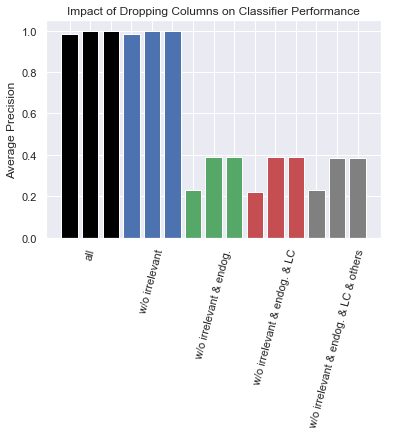

In [63]:
# Convert average precision to pd.Series 
average_precision = pd.Series(average_precision)
fig, ax = plt.subplots()
ind = np.arange(1, len(average_precision) + 1)
# colors to use
colors = ['black', 'b', 'g', 'r', 'gray']
# Use each color three times
colors = [[c, c, c] for c in colors]
# Flatten color list
colors = [c for c_list in colors for c in c_list]

# Create bar plot
ax.bar(x=ind, 
       height=average_precision.values,
       align='center', color=colors)
ax.set_title('Impact of Dropping Columns on Classifier Performance')
ax.set_ylabel('Average Precision')
ax.tick_params(axis='x', rotation=75)
ax.set_xticks(ind)
x_ticks = ['', 'all', '',
           '', 'w/o irrelevant', '',
           '', 'w/o irrelevant & endog.', '',
           '', 'w/o irrelevant & endog. & LC', '',
           '', 'w/o irrelevant & endog. & LC & others', '']
ax.set_xticklabels(x_ticks);

Note that each color corresponds to a specific subset of features. For each of these data sets, the leftmost column gives the performance of the random forests classifier, the middle column gives the performance of logistic regression, and the rightmost column gives the performance of a linear support vector classifier.

We see that the main thing that matters is whether we exclude endogenous variables are not (black and blue bars versus the rest).  This is not surprising: Since these variables were often generated after the loan outcome was already observed, it is natural that they can be used to predict the outcome pretty accurately. As a result, it is easy to be misled into thinking that one's model is more powerful than it actually is. This justifies my substantial time investment into data cleaning, because it is easy to overlook some of the endogenous variables, as the data dictionary is not always clear.

Whether we drop irrelevant variables (black versus blue) has no detectable impact, because regularization in combination with our large sample size are able to sort out this additional noise. 

The same is true of a group of variables I call "LC", which stands for Lending Club. These variables are based on Lending Club's predictive models (e.g., loan grade). While these factors are clearly predictive of loan default, all the information they contain should already be contained in my own analysis.  As a result, dropping them does not hurt predictive accuracy.

Finally, I dropped a group of variables I termed "other". These contain mostly noise, as  they are near-duplicates of other variables already included in my models. However, an additional reason for dropping them was that they may also contain the results from someone else's predictive models: One such variable is the amount of the loan funded through Lending Club's investors. While this is usually the same as the total amount funded, a discrepancy between the two amounts is likely to signal that Lending Club's investors perceived an increased default risk. As explained in more detail in the data cleaning notebook, we do not want to use this information,because we want to make our own prediction, and because the extent to which the investors will fund a loan is not yet known when the decision to approve a loan is made. 

In [8]:
# Print most important features 
for name, importance in most_important_features.items():
    print(name, ':\n', importance, '\n')

('random forests', 'all') :
 last_fico_range_low        0.174427
last_fico_range_high       0.169137
last_pymnt_amnt            0.122006
total_rec_prncp            0.086501
recoveries                 0.082719
collection_recovery_fee    0.077290
total_pymnt_inv            0.043787
total_pymnt                0.043073
funded_amnt                0.019046
loan_amnt                  0.016618
dtype: float64 

('logistic regression', 'all') :
 funded_amnt                56.481623
funded_amnt_inv            45.582298
recoveries                 39.155220
collection_recovery_fee    26.078198
total_rec_int              23.821944
loan_amnt                  22.639980
x10_Y                       9.071286
x6_wedding                  4.866007
x2_D1                       4.650125
x2_A2                       3.173689
dtype: float64 

('random forests', 'w/o irrelevant') :
 last_fico_range_low        0.166369
last_pymnt_amnt            0.123746
last_fico_range_high       0.122666
total_rec_prncp          

In [9]:
# Print classification reports 
for name, report in classification_reports.items():
    print(name, ':\n', report, '\n')

('random forests', 'all') :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7939
           1       1.00      0.96      0.98      2061

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.98      0.99     10000
weighted avg       0.99      0.99      0.99     10000
 

('logistic regression', 'all') :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7939
           1       1.00      0.99      1.00      2061

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000
 

('SVM', 'all') :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7939
           1       0.99      1.00      0.99      2061

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00

# OLDER

In [ ]:
# Plot confusion matrix
y_pred_svm = svm.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_svm)

# Plot ROC curve
y_pred_proba_svm = svm.decision_function(X_test_p)
plot_roc(y_test, y_pred_proba_svm)

In [ ]:
plot_precision_recall(y_test, y_pred_proba_lr)

In [ ]:
#     def plot_confusion_matrix(y_test, y_pred, digits=3):
#         cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
#                                           labels=[1,0]),
#                           columns=['True', 'False'])
#         cf.index=['True', 'False']
#         cf.columns.name = 'Predicted'
#         cf.index.name = 'Actual'
#         print(round(cf / len(y_test), digits))    

#     # Plot confusion matrix for random forests
#     y_pred_rf = rf.predict(X_test_p)
#     plot_confusion_matrix(y_test, y_pred_rf)


#     def plot_roc(y_test, y_pred, model_name=None):
#         false_positive_rate, true_positive_rate, thresholds = \
#             roc_curve(y_test, y_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         plt.plot(false_positive_rate, true_positive_rate, 'b',
#                  label='AUC = {0:.3f}'.format(roc_auc))
#         plt.legend(loc='lower right')
#         plt.plot([0, 1],[0, 1], 'r--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         title='ROC Curve'
#         # Add custom title, if specified
#         if model_name is not None:
#             title = ', '.join([title, model_name])
#         plt.title(title)
#         plt.show();

#     # Plot ROC curve for random forests
#     y_pred_proba_rf = rf.predict_proba(X_test_p)[:, 1]
#     plot_roc(y_test, y_pred_proba_rf, 'Random Forests')


#     def plot_precision_recall(y_test, y_pred):
#         """Plots precision-recall curve."""

#         average_precision = average_precision_score(y_test, y_pred)
#         precision, recall, _ = precision_recall_curve(y_test, y_pred)
#         # pdb.set_trace()
#         step_kwargs = ({'step': 'post'}
#                        if 'step' in signature(plt.fill_between).parameters
#                        else {})
#         plt.step(recall, precision, color='b', alpha=0.2,
#                  where='post')
#         plt.figtext(0.2, 0.2, 'Average Precision={0:0.3f}' \
#                                         .format(average_precision))
#         plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#         plt.xlabel('Recall')
#         plt.ylabel('Precision')
#         plt.ylim([0.0, 1.05])
#         plt.xlim([0.0, 1.0])
#         plt.title('Precision-Recall curve')
#         plt.show();

#     # Plot precision recall curve for random forests classifier
#     plot_precision_recall(y_test, y_pred_proba_rf)

#     # Get a list of feature names
#     cat_names = preprocessor.named_transformers_['cat'] \
#                     .named_steps['onehot'].get_feature_names()
#     feature_names = list(numeric_features) + list(cat_names)
#     # Compute feature importance and sort
#     feature_importances = pd.Series(
#                                 rf.feature_importances_,
#                                 index=feature_names) \
#                             .sort_values(ascending=False)
#     print(feature_importances)

In [ ]:
plot_precision_recall(y_test, y_pred_proba_svm)

In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
variables_to_drop